# Single-Stage Vapor Compression Machine Simulation
---

Evaporation temperature and condensation temperature will settle at steady-state regime to a value that, for a given compressor speed, also depends on the conditions prevailing on the other side of the evaporator and condenser respectively. These conditions are influenced by a number of factors, like the inlet state and mass flow rate of the low temperature medium at the evaporator side, the state and mass flow rate of the high temperature medium at the condenser side, and the construction or geometry of the evaporator and condenser.  

With the class `SingleStageVCMachine` in `hvac.vapor_compression` the evaporation and condensation temperature can be determined for given working conditions at the evaporator and condenser non-refrigerant side. These working conditions are determined by:
- the mass flow rate of the low and high temperature medium on the other side of the evaporator and condenser respectively
- the state of the low and high temperature medium at the inlet of the evaporator and condenser respectively
- the effectiveness of the evaporator and condenser, which is not a constant figure, but depends mainly on the mass flow rates

The class `SingleStageVCMachine` exspects that low and high temperature media are air streams (instances of class `HumidAir`). 

Once evaporation and condensing temperature have been determined, the performance parameters of the single stage machine can also be determined.

In [1]:
from deps import load_packages

load_packages()

In [2]:
from pathlib import Path
import numpy as np

from hvac import Quantity
from hvac.fluids import Fluid, HumidAir
from hvac.vapor_compression import FixedSpeedCompressor, SingleStageVCMachine
from hvac.charts import LineChart

In [3]:
Q_ = Quantity

To instantiate a model (object) of the `SingleStageVCMachine` class, we need to specify at least: 
- the compressor model (parameter `compressor`)
- the effectiveness of the condenser (parameter `eps_con`)
- the effectiveness of the evaporator (parameter `eps_eva`)
- the mass flow rate of the low temperature medium at the evaporator side (parameter `lt_ma`)
- the mass flow rate of the high temperature medium at the condenser side (parameter `ht_ma`)

Optionally, the inlet state of the low temperature and high temperature medium can also be set at the time of instantiation (parameters `lt_air_in` and `ht_air_in`). Evaporation and condensing temperature will then be calculated on instantiation and can be accessed through the properties `Te` and `Tc`. Consequently, performance parameters are immediately available after instantiation. These performance parameters are:
- cooling capacity: property `Qc_dot`
- heating capacity: property `Qh_dot`
- compressor power: property `Wc_dot`
- coefficient of performance: property `COP`
- refrigerant mass flow rate: property `m_dot`

Besides the performance parameters, refrigerant states are also determined:
- at the evaporator outlet = at the compressor entrance: property `suction_gas`
- at the condenser inlet = at the compressor exit: property `discharge_gas`
- at the condenser outlet = at entrance of expansion device: property `liquid`
- at the evaporator inlet = at exit of expansion device: property `mixture`

In order to evaluate the performance at different working conditions, one can change conditions after instantiation by using the properties:
- `lt_air_in`: set the state of the low temperature inlet air at the evaporator
- `ht_air_in`: set the state of the high temperature inlet air at the condensor
- `speed`: set the speed of the compressor, if the compressor has variable speed (instance of `VariableSpeedCompressor`)

The mass flow rate of the air streams cannot be changed after instantiation, as changing the mass flow rate will also alter the effectiveness of evaporator or condensor.

After setting new working conditions, a call to `simulate` will recalculate evaporation and condensing temperature.

## Example of a Single-Stage Vapor Compression Machine with Fixed Speed Compressor

**Compressor with refrigerant R22**

First thing to do, is to create a `FixedSpeedCompressor` instance (see also notebook *compressor.ipynb*):

In [4]:
data_folder = Path("../compressor_data")
file = data_folder / "ZR144KCE-TFD.csv"

In [5]:
R22 = Fluid('R22')

In [6]:
compressor = FixedSpeedCompressor(
    coeff_file=file,      # file with polynomial coefficients from manufacturer
    dT_sh=Q_(10, 'K'),    # amount of suction superheat for which the coefficients are valid
    dT_sc=Q_(0, 'K'),     # amount of subcooling for which the coefficients are valid
    refrigerant_type=R22  # type of refrigerant
)

FileNotFoundError: [Errno 2] No such file or directory: '..\\compressor_data\\ZR144KCE-TFD.csv'

**Condenser**

Condition of inlet air at entrance of condenser:

In [8]:
condenser_air_in = HumidAir(Tdb=Q_(40, 'degC'), RH=Q_(50, 'pct'))

Mass flow rate of air through condenser:

In [9]:
ma_con = Q_(3.911, 'kg/s')

Condenser effectiveness:

In [10]:
eps_con = Q_(71.19, 'pct')

**Evaporator**

Condition of inlet air at entrance of evaporator:

In [11]:
evaporator_air_in = HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct'))

Mass flow rate of air through evaporator:

In [12]:
ma_eva = Q_(1.097, 'kg/s')

Evaporator effectiveness:

In [13]:
eps_eva = Q_(60.18, 'pct')

**Instantiation of class `SingleStageVCMachine`**

In [14]:
machine = SingleStageVCMachine(
    compressor=compressor,
    eps_con=eps_con,
    eps_eva=eps_eva,
    lt_ma=ma_eva,
    ht_ma=ma_con
)

**Set working conditions**

At condenser:

In [15]:
machine.ht_air_in = condenser_air_in

At evaporator:

In [16]:
machine.lt_air_in = evaporator_air_in

**Run simulation**

In [17]:
machine.simulate()

**Get performance parameters**

In [18]:
print(
    f"cooling capacity `Qc_dot`: {machine.Qc_dot.to('kW'):~P.3f}\n"
    f"heating capacity `Qh_dot`: {machine.Qh_dot.to('kW'):~P.3f}\n"
    f"compressor power `Wc_dot`: {machine.Wc_dot.to('kW'):~P.3f}\n"
    f"COP: {machine.COP.to('frac'):~P.2f}\n"
    f"mass flow rate of refrigerant `m_dot`: {machine.m_dot.to('kg / s'):~P.3f}"
)

cooling capacity `Qc_dot`: 25.608 kW
heating capacity `Qh_dot`: 35.178 kW
compressor power `Wc_dot`: 9.570 kW
COP: 2.68 frac
mass flow rate of refrigerant `m_dot`: 0.175 kg/s


**Get evaporation and condensing temperature at current working conditions**

In [19]:
print(
    f"evaporation temperature `Te`: {machine.Te.to('degC'):~P.1f}\n"
    f"condensing temperature `Tc`: {machine.Tc.to('degC'):~P.1f}"
)

evaporation temperature `Te`: -0.2 °C
condensing temperature `Tc`: 52.4 °C


The corresponding evaporator and condenser pressure can be retrieved from refrigerant states:

In [20]:
print(
    f"evaporator pressure: {machine.mixture.P.to('bar'):~P.0f}\n"
    f"condensor pressure: {machine.liquid.P.to('bar'):~P.0f}\n"
)

evaporator pressure: 5 bar
condensor pressure: 21 bar



## Analysis of the Single-Stage Vapor Compression Machine for a Range of Condenser Air Inlet Temperatures (Outside Air Temperatures)

We will expand the example above to analyze machine performance at different condenser air inlet temperatures. This machine could be an air conditioning unit used to cool a room, such that the room temperature will remain constant and equal to the air inlet condition we already have set for the evaporator (24 °C). The condenser is located outdoors and may be subjected to a wide range of outdoor temperatures. 

To create a range of condenser air inlet temperatures, we will use the **[Numpy](https://numpy.org/)** library, imported above as `np`:

In [21]:
T_ai_con_range = Q_(np.arange(28, 41, 1), 'degC')

We will repeat the above example for each temperature within this range. For this, we will use a `for`-loop and to temporarily store results, we create a number of lists:

In [22]:
Qc_dot_range = []  # cooling capacities
Wc_dot_range = []  # compressor powers
m_dot_range = []   # mass flow rates
COP_range = []     # COPs
Tc_range = []      # evaporating temperatures
Te_range = []      # condensing temperatures

In [23]:
for T_ai_con in T_ai_con_range:
    machine.ht_air_in = HumidAir(Tdb=T_ai_con, W=condenser_air_in.W)  # we keep air humidity constant
    machine.simulate()
    Qc_dot_range.append(machine.Qc_dot)
    Wc_dot_range.append(machine.Wc_dot)
    m_dot_range.append(machine.m_dot)
    COP_range.append(machine.COP)
    Tc_range.append(machine.Tc)
    Te_range.append(machine.Te)

To have a better view over the results, we will show them in line charts. Class `LineChart` provides a thin wrapper around the third-party library **[matplotlib](https://matplotlib.org/)**.

### Cooling Capacity in function of Outside Air Temperature

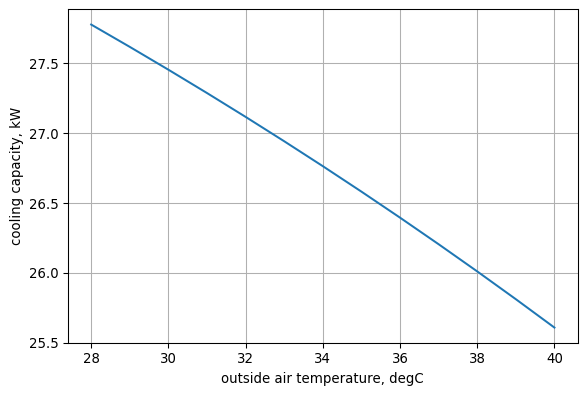

In [24]:
chart1 = LineChart(size=(6, 4), dpi=96)
chart1.add_xy_data(
    label='Qc_dot',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[Qc_dot.to('kW').m for Qc_dot in Qc_dot_range]
)
chart1.x1.add_title('outside air temperature, degC')
chart1.y1.add_title('cooling capacity, kW')
chart1.show()

As outdoor air temperature (and cooling load of the room) drops, the cooling capacity of the vapor compression machine on the other hand increases. Control measures will be necessary to match the cooling capacity of the machine with the cooling load of the room at part-load. 

### Compressor Power in function of Outside Air Temperature

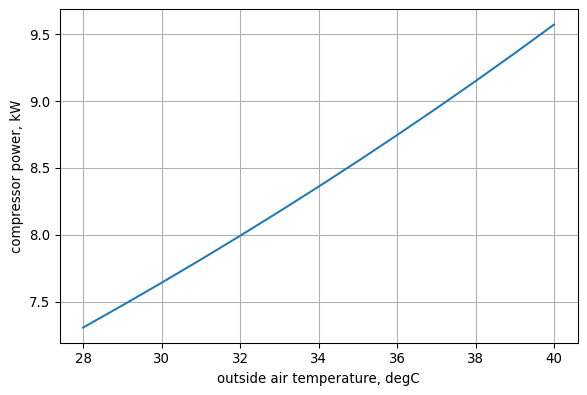

In [25]:
chart2 = LineChart(size=(6, 4), dpi=96)
chart2.add_xy_data(
    label='Wc_dot',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[Wc_dot.to('kW').m for Wc_dot in Wc_dot_range]
)
chart2.x1.add_title('outside air temperature, degC')
chart2.y1.add_title('compressor power, kW')
chart2.show()

As outdoor air temperature drops, compressor power drops also (while cooling capacity is raising).

### COP in function of Outside Air Temperature

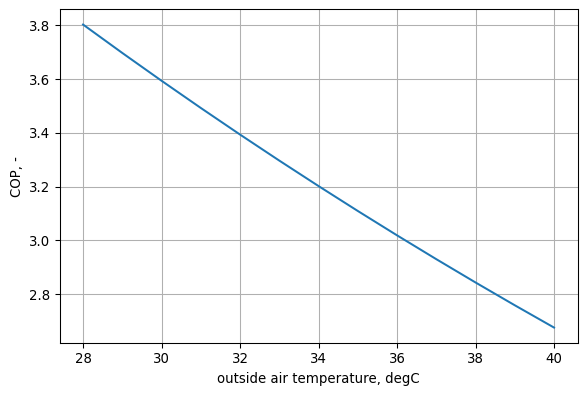

In [26]:
chart3 = LineChart(size=(6, 4), dpi=96)
chart3.add_xy_data(
    label='COP',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[COP.to('frac').m for COP in COP_range]
)
chart3.x1.add_title('outside air temperature, degC')
chart3.y1.add_title('COP, -')
chart3.show()

As expected, if cooling capacity raises and compressor power drops with decreasing outside air temperatures, the COP of the cooling machine must increase.

### Refrigerant Mass Flow Rate in function of Outside Air Temperature

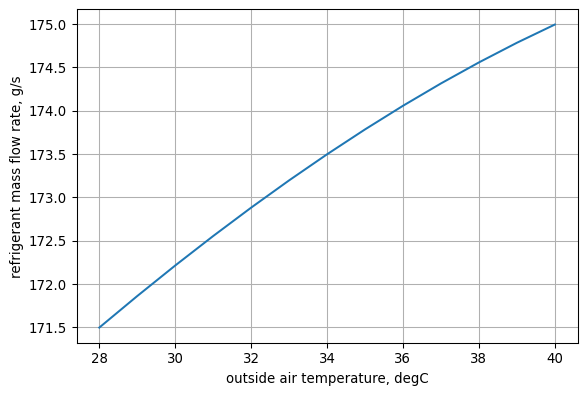

In [27]:
chart4 = LineChart(size=(6, 4), dpi=96)
chart4.add_xy_data(
    label='m_dot',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[m_dot.to('g / s').m for m_dot in m_dot_range]
)
chart4.x1.add_title('outside air temperature, degC')
chart4.y1.add_title('refrigerant mass flow rate, g/s')
chart4.show()

As outdoor air temperature drops, the refrigerant mass flow rate circulated by the compressor also decreases. 

### Evaporation Temperature in function of Outside Air Temperature 

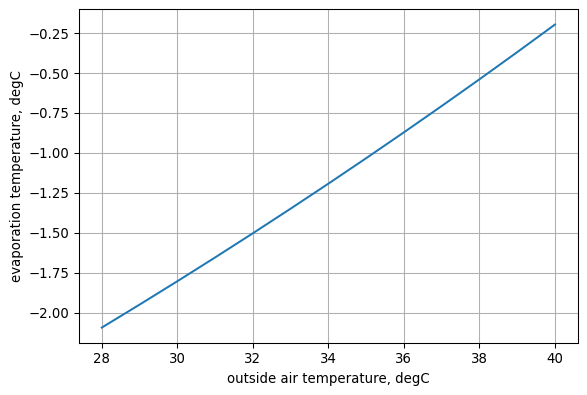

In [28]:
chart5 = LineChart(size=(6, 4), dpi=96)
chart5.add_xy_data(
    label='Te',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[Te.to('degC').m for Te in Te_range]
)
chart5.x1.add_title('outside air temperature, degC')
chart5.y1.add_title('evaporation temperature, degC')
chart5.show()

### Condensation Temperature in function of Outside Air Temperature

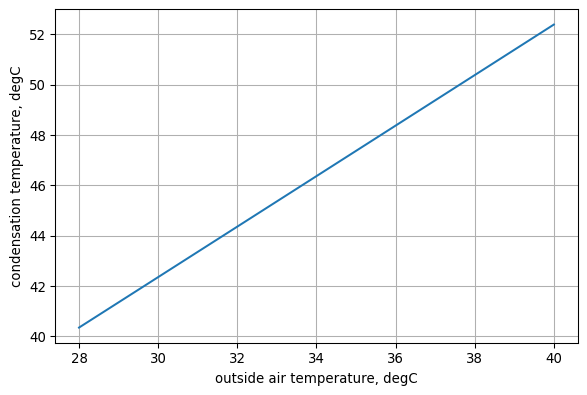

In [29]:
chart6 = LineChart(size=(6, 4), dpi=96)
chart6.add_xy_data(
    label='Tc',
    x1_values=[Tai.to('degC').m for Tai in T_ai_con_range],
    y1_values=[Tc.to('degC').m for Tc in Tc_range]
)
chart6.x1.add_title('outside air temperature, degC')
chart6.y1.add_title('condensation temperature, degC')
chart6.show()